# Multi-Fold Fusion Sweep Report

Sweep previously generated per-stream logits across all folds, search small weight/temperature grids for the best late-fusion combination, and rank folds by eval accuracy. Handles the nested `./workdir/workdir` quirk automatically.


In [1]:
import os
import re
import json
from itertools import product
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.style.use('ggplot')

STREAMS = ['J', 'B', 'JM', 'BM']
CLASS_NAMES = ['Transit', 'Social_People', 'Play_Object_Normal']
BASE_WORKDIR = Path('./workdir')

# Weight/temperature grids (keep small so it runs fast)
WEIGHT_GRID = [
    [0.25, 0.25, 0.25, 0.25],
    [0.35, 0.2, 0.2, 0.25],
    [0.3, 0.2, 0.3, 0.2],
    [0.2, 0.3, 0.25, 0.25],
]
TEMP_GRID = [0.8, 1.0, 1.2]
RUN_TAG = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f'Run tag: {RUN_TAG}, base workdir: {BASE_WORKDIR.resolve()}')


Run tag: 20251203_202023, base workdir: /Users/alexeidelgado/Desktop/mpgcn-playground-scenes/workdir


In [2]:
def resolve_score_path(fold_id, stream, base_workdir=BASE_WORKDIR):
    """Locate score_eval.npz for a stream, tolerating nested workdir/workdir."""
    candidates = [
        Path(base_workdir) / f"fold_{fold_id}_{stream}" / 'score_eval.npz',
        Path(base_workdir) / 'workdir' / f"fold_{fold_id}_{stream}" / 'score_eval.npz',
    ]
    for cand in candidates:
        if cand.exists():
            return cand
    raise FileNotFoundError(f'Missing score_eval.npz for fold {fold_id}, stream {stream}')


def load_stream_scores(fold_id, streams=STREAMS, base_workdir=BASE_WORKDIR):
    logits_bank = {}
    labels_ref = None
    names_ref = None
    for s in streams:
        path = resolve_score_path(fold_id, s, base_workdir)
        data = np.load(path, allow_pickle=True)
        logits, labels, names = data['logits'], data['labels'], data['names']
        if labels_ref is None:
            labels_ref, names_ref = labels, names
        else:
            if not np.array_equal(labels_ref, labels):
                raise ValueError(f'Label mismatch for fold {fold_id}')
            if not np.array_equal(names_ref, names):
                raise ValueError(f'Name/order mismatch for fold {fold_id}')
        logits_bank[s] = logits
    return logits_bank, labels_ref, names_ref


def fuse_logits(logits_list, weights):
    w = np.array(weights, dtype=np.float32)
    w = w / w.sum()
    fused = np.zeros_like(logits_list[0], dtype=np.float32)
    for logit, weight in zip(logits_list, w):
        fused += logit * weight
    return fused, w


def compute_metrics(logits, labels, class_names=CLASS_NAMES):
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    report = classification_report(
        labels,
        preds,
        labels=list(range(len(class_names))),
        target_names=class_names,
        output_dict=True,
        zero_division=0,
    )
    cm = confusion_matrix(labels, preds, labels=list(range(len(class_names))))
    report_df = pd.DataFrame(report).T
    return {
        'accuracy': float(acc),
        'macro_f1': float(report_df.loc['macro avg', 'f1-score']),
        'weighted_f1': float(report_df.loc['weighted avg', 'f1-score']),
        'report_df': report_df,
        'cm': cm,
        'preds': preds,
    }


def sweep_fold(fold_id, streams=STREAMS, weight_grid=WEIGHT_GRID, temp_grid=TEMP_GRID):
    logits_bank, labels, names = load_stream_scores(fold_id, streams, BASE_WORKDIR)
    best = {'acc': -1, 'weights': None, 'temps': None}
    logits_list = [logits_bank[s] for s in streams]

    for weights in weight_grid:
        for temps in product(temp_grid, repeat=len(streams)):
            temped = [logit / t for logit, t in zip(logits_list, temps)]
            fused, norm_w = fuse_logits(temped, weights)
            metrics = compute_metrics(fused, labels, CLASS_NAMES)
            if metrics['accuracy'] > best['acc']:
                best.update({
                    'acc': metrics['accuracy'],
                    'weights': norm_w,
                    'temps': temps,
                    'metrics': metrics,
                    'fused_logits': fused,
                    'labels': labels,
                    'names': names,
                })
    return best


def discover_folds(base_workdir=BASE_WORKDIR, streams=STREAMS):
    folds = set()
    pattern = re.compile(r"fold_(\d{2})_" + streams[0])
    for path in base_workdir.glob('fold_*_*'):
        m = pattern.match(path.name)
        if m:
            folds.add(m.group(1))
    # also look under nested workdir
    nested = base_workdir / 'workdir'
    if nested.exists():
        for path in nested.glob('fold_*_*'):
            m = pattern.match(path.name)
            if m:
                folds.add(m.group(1))
    return sorted(folds)


In [3]:
# Sweep all discovered folds
fold_ids = discover_folds(BASE_WORKDIR, STREAMS)
print(f'Discovered folds: {fold_ids}')
results = []
best_fold = None
best_acc = -1
best_payload = None

for fid in fold_ids:
    try:
        res = sweep_fold(fid, STREAMS, WEIGHT_GRID, TEMP_GRID)
        row = {
            'Fold': fid,
            'Best_Acc': res['acc'],
            'Weights': res['weights'],
            'Temps': res['temps'],
        }
        results.append(row)
        if res['acc'] > best_acc:
            best_acc = res['acc']
            best_fold = fid
            best_payload = res
        print(f"Fold {fid}: acc={res['acc']:.4f} weights={res['weights']} temps={res['temps']}")
    except Exception as exc:
        print(f'Fold {fid} skipped: {exc}')

summary_df = pd.DataFrame(results).sort_values(by='Best_Acc', ascending=False)
print('Top folds by fused accuracy:')
display(summary_df.head(10))


Discovered folds: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
Fold 00: acc=0.6758 weights=[0.3 0.2 0.3 0.2] temps=(1.0, 1.0, 0.8, 0.8)
Fold 01: acc=0.6928 weights=[0.25 0.25 0.25 0.25] temps=(0.8, 0.8, 1.2, 1.0)
Fold 02: acc=0.6793 weights=[0.35 0.2  0.2  0.25] temps=(1.0, 0.8, 1.0, 0.8)
Fold 03: acc=0.6884 weights=[0.35 0.2  0.2  0.25] temps=(0.8, 1.0, 0.8, 0.8)
Fold 04: acc=0.6745 weights=[0.25 0.25 0.25 0.25] temps=(0.8, 0.8, 1.2, 1.0)
Fold 05: acc=0.6881 weights=[0.2  0.3  0.25 0.25] temps=(1.0, 0.8, 1.0, 1.2)
Fold 06: acc=0.6725 weights=[0.35 0.2  0.2  0.25] temps=(0.8, 1.2, 1.2, 1.2)
Fold 07: acc=0.6828 weights=[0.35 0.2  0.2  0.25] temps=(1.0, 0.8, 1.2, 1.0)
Fold 08: acc=0.6952 weights=[0.2  0.3  0.25 0.25] temps=(1.0, 0.8, 1.2, 0.8)
Fold 09: acc=0.6829 weights=[0.3 0.2 0.3 0.2] temps=(0.8, 0.8, 1.2, 1.0)
Fold 10: acc=0.6986 weights=[0.25 0.25 0.25 0.25] temps=(0.8, 1.2, 0.

,Fold,Best_Acc,Weights,Temps
22,22,0.706897,"[0.2, 0.3, 0.25, 0.25]","(1.2, 0.8, 1.0, 1.0)"
19,19,0.703833,"[0.35, 0.2, 0.2, 0.25]","(0.8, 1.0, 0.8, 1.2)"
10,10,0.698630,"[0.25, 0.25, 0.25, 0.25]","(0.8, 1.2, 0.8, 1.2)"
17,17,0.696246,"[0.25, 0.25, 0.25, 0.25]","(0.8, 0.8, 0.8, 1.0)"
8,08,0.695205,"[0.2, 0.3, 0.25, 0.25]","(1.0, 0.8, 1.2, 0.8)"
23,23,0.693878,"[0.25, 0.25, 0.25, 0.25]","(1.2, 0.8, 1.2, 0.8)"
1,01,0.692833,"[0.25, 0.25, 0.25, 0.25]","(0.8, 0.8, 1.2, 1.0)"
13,13,0.692308,"[0.35, 0.2, 0.2, 0.25]","(0.8, 1.0, 0.8, 1.0)"
12,12,0.690476,"[0.2, 0.3, 0.25, 0.25]","(1.0, 1.2, 1.2, 0.8)"
3,03,0.688356,"[0.35, 0.2, 0.2, 0.25]","(0.8, 1.0, 0.8, 0.8)"


Best fold: 22 acc=0.7069


,precision,recall,f1-score,support
Transit,0.703252,0.955801,0.810304,181.0
Social_People,0.731707,0.454545,0.560748,66.0
Play_Object_Normal,0.666667,0.046512,0.086957,43.0
macro avg,0.700542,0.485619,0.486003,290.0
weighted avg,0.704303,0.706897,0.646254,290.0


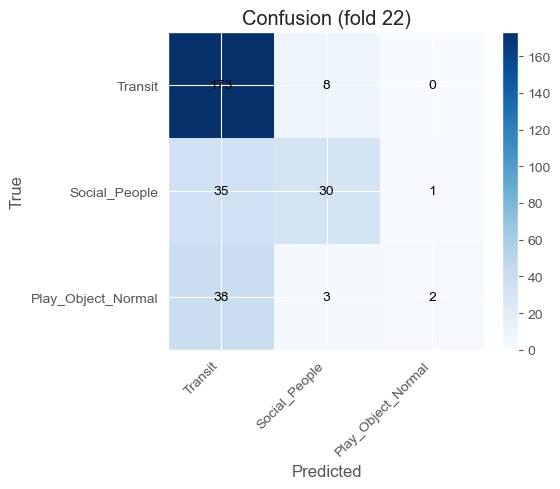

In [4]:
# Inspect best fold details and confusion matrix
if best_payload is None:
    print('No valid folds found.')
else:
    print(f"Best fold: {best_fold} acc={best_payload['acc']:.4f}")
    report_df = best_payload['metrics']['report_df']
    display(report_df.loc[CLASS_NAMES + ['macro avg', 'weighted avg']])
    cm = best_payload['metrics']['cm']

    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f'Confusion (fold {best_fold})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(len(CLASS_NAMES)))
    ax.set_yticks(range(len(CLASS_NAMES)))
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
    ax.set_yticklabels(CLASS_NAMES)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


In [5]:
# Save summary to disk for later reference
out_dir = BASE_WORKDIR / 'fusion_sweeps'
out_dir.mkdir(parents=True, exist_ok=True)
summary_path = out_dir / f'fusion_sweep_summary_{RUN_TAG}.csv'
summary_df.to_csv(summary_path, index=False)
print(f'Saved sweep summary to {summary_path}')

if best_payload is not None:
    np.savez(
        out_dir / f'best_fold_{best_fold}_fused_logits.npz',
        logits=best_payload['fused_logits'],
        labels=best_payload['labels'],
        names=best_payload['names'],
        weights=best_payload['weights'],
        temps=np.array(best_payload['temps']),
        streams=np.array(STREAMS),
    )
    with open(out_dir / f'best_fold_{best_fold}_metrics.json', 'w') as f:
        json.dump(
            {
                'fold': best_fold,
                'accuracy': best_payload['acc'],
                'weights': best_payload['weights'].tolist(),
                'temps': list(best_payload['temps']),
                'class_names': CLASS_NAMES,
                'confusion_matrix': best_payload['metrics']['cm'].tolist(),
            },
            f,
            indent=2,
        )
    print(f"Saved best fold artifacts under {out_dir}")


Saved sweep summary to workdir/fusion_sweeps/fusion_sweep_summary_20251203_202023.csv
Saved best fold artifacts under workdir/fusion_sweeps
